In [896]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier as dtc 
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree


In [897]:
df = pd.read_csv("Match_Information_cleaned.csv")

In [898]:
df.head()

,gameId,gameDuration,gameVersion,platformId,season,winner,1st_baron,1st_dragon,1st_inhibitor,1st_riftHerald,...,t2_baron_kills,t2_champ_kills,t2_dragon_kills,t2_inhibitor_kills,t2_riftHerald_kills,t2_tower_kills,t2_team_assists,t2_team_gold_earn,t2_team_gold_spen,t2_team_kda
0,1245810008,43.0,11.22.406.3587,EUW1,11,2,1,1,2,1,...,2,52,4,5,1,11,58,89056,86000,2.619048
1,1245827001,20.0,11.22.406.3587,EUW1,11,1,0,2,1,1,...,0,25,1,0,1,0,37,39261,37685,1.476190
2,1243137392,33.0,11.22.406.3587,EUW1,11,2,1,2,2,1,...,0,35,4,1,0,7,53,63064,56970,3.259259
3,1243091838,32.0,11.22.406.3587,EUW1,11,2,2,1,2,2,...,2,43,2,5,1,11,66,71984,63978,3.114286
4,770956820,51.0,11.2.353.8505,EUW1,11,1,2,2,1,1,...,1,66,2,1,0,8,93,103306,96280,1.915663


Removing time less than 15 minutes, and less situations based on lol_data_analyse result

In [899]:
df = df[(df['gameDuration'] >= 15.0) & (df['gameDuration'] <= 60.0) & (df['t1_baron_kills'] <= 3) & (df["t1_dragon_kills"] <= 5) & (df["t1_inhibitor_kills"] <= 6) & (df["t1_team_kda"] <= 10) & (df['t2_baron_kills'] <= 3) & (df["t2_dragon_kills"] <= 5) & (df["t2_inhibitor_kills"] <= 7) & (df["t2_team_kda"] <= 10)]

In [900]:
df.columns

Index(['gameId', 'gameDuration', 'gameVersion', 'platformId', 'season',
       'winner', '1st_baron', '1st_dragon', '1st_inhibitor', '1st_riftHerald',
       '1st_tower', 't1_baron_kills', 't1_champ_kills', 't1_dragon_kills',
       't1_inhibitor_kills', 't1_riftHerald_kills', 't1_tower_kills',
       't1_team_assists', 't1_team_gold_earn', 't1_team_gold_spen',
       't1_team_kda', 't2_baron_kills', 't2_champ_kills', 't2_dragon_kills',
       't2_inhibitor_kills', 't2_riftHerald_kills', 't2_tower_kills',
       't2_team_assists', 't2_team_gold_earn', 't2_team_gold_spen',
       't2_team_kda'],
      dtype='object')

In [902]:
model_1 = df[['winner','1st_tower','t1_baron_kills','t1_dragon_kills', 't1_tower_kills',
            't1_inhibitor_kills', 't1_riftHerald_kills', 't2_baron_kills','t2_dragon_kills', 
            't2_tower_kills','t2_inhibitor_kills', 't2_riftHerald_kills']]

Using stratified sampling to set 80% data as training set and 20% as testing set

In [903]:
df['winner'].value_counts()

1    9690
2    9248
Name: winner, dtype: int64

In [904]:
x = model_1.drop('winner', axis=1)
y = model_1['winner']

x_train_set_1, x_test_set_1, y_train_set_1, y_test_set_1 = train_test_split(x, y, test_size=0.2, stratify=y, random_state=4)

x_train_set_1.shape
x_test_set_1.shape

(15150, 11)

(3788, 11)

In [906]:
parameters = {
    'criterion':('gini', 'entropy'),
    'splitter': ('best', 'random'),
    'max_depth':[*range(1, 20, 2)],
}
 
clf = dtc(random_state=4)
model = GridSearchCV(clf, parameters, cv=10)
model.fit(x_train_set_1, y_train_set_1)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})

In [907]:
model.best_score_
model.best_params_

0.9647524752475247

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}

In [908]:
x_train_set_1.columns

Index(['1st_tower', 't1_baron_kills', 't1_dragon_kills', 't1_tower_kills',
       't1_inhibitor_kills', 't1_riftHerald_kills', 't2_baron_kills',
       't2_dragon_kills', 't2_tower_kills', 't2_inhibitor_kills',
       't2_riftHerald_kills'],
      dtype='object')

In [922]:
best_model = dtc(criterion = 'gini', max_depth = 7, splitter = 'best')
best_model.fit(x_train_set_1, y_train_set_1)

print("score:", best_model.score(x_test_set_1,y_test_set_1))   

DecisionTreeClassifier(max_depth=7)

score: 0.9593453009503696


In [910]:
imp = pd.DataFrame(list(zip(x_train_set_1.columns, best_model.feature_importances_)))
imp.columns = ['columns', 'importances_score']
imp = imp.sort_values('importances_score', ascending=False)
imp

,columns,importances_score
9,t2_inhibitor_kills,0.605409
3,t1_tower_kills,0.288921
8,t2_tower_kills,0.063403
4,t1_inhibitor_kills,0.010424
2,t1_dragon_kills,0.008327
7,t2_dragon_kills,0.006837
6,t2_baron_kills,0.005497
1,t1_baron_kills,0.004459
0,1st_tower,0.004375
10,t2_riftHerald_kills,0.002235


In [911]:
best_model.feature_importances_

array([4.37468601e-03, 4.45862552e-03, 8.32729599e-03, 2.88920926e-01,
       1.04241211e-02, 1.14165035e-04, 5.49708068e-03, 6.83732387e-03,
       6.34026294e-02, 6.05408608e-01, 2.23453811e-03])

In [912]:
feature_names = model_1.columns[:15]
target_names = df['winner'].unique().tolist()

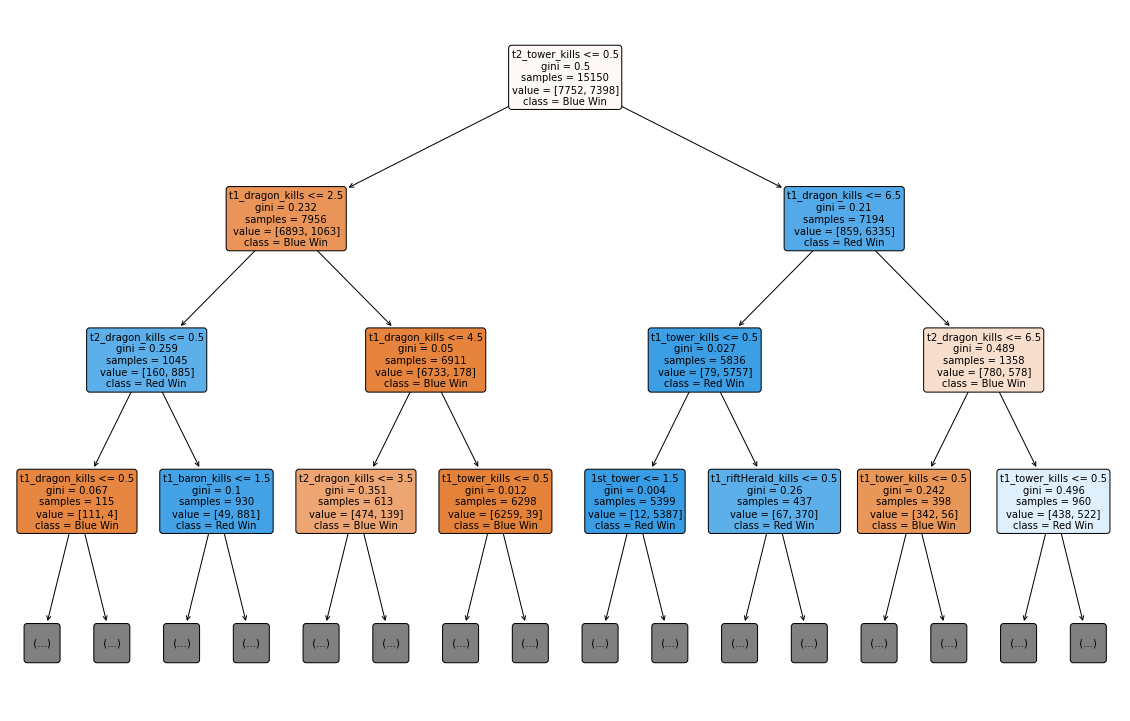

In [913]:
plt.figure(figsize=(20, 13))

doa = plot_tree(best_model, max_depth=3,
            feature_names = feature_names, 
            class_names = ['Blue Win', 'Red Win'], 
            filled = True, 
            rounded = True, fontsize = 10)


plt.savefig('tree_visualization.png');

In [929]:
new_data = [[1, 1, 2, 3, 0, 1, 2, 4, 11, 5, 1]]
c = best_model.predict_proba(new_data)
print("winner is :" , best_model.predict(new_data))

winner is : [2]
First team win probability is 0.0 % 
Second team win probability is 100.0 %


In [921]:
scores = cross_validate(best_model, x_test_set_1, y_test_set_1, cv=10, scoring=('accuracy'), return_train_score=True)

print(scores)
print('average accuracy: {:.4f}'.format(np.mean(scores['test_score']))) 

{'fit_time': array([0.00591421, 0.00534105, 0.00483918, 0.00451088, 0.00396514,
       0.00413585, 0.0038681 , 0.00396204, 0.00385809, 0.00362206]), 'score_time': array([0.00128698, 0.00113297, 0.00115371, 0.0009141 , 0.00088286,
       0.00110006, 0.00096583, 0.00099301, 0.00079799, 0.00084496]), 'test_score': array([0.95514512, 0.95778364, 0.96306069, 0.96042216, 0.96042216,
       0.96306069, 0.95778364, 0.96569921, 0.94179894, 0.93650794]), 'train_score': array([0.97799941, 0.97477266, 0.97653271, 0.97799941, 0.975066  ,
       0.97799941, 0.97682605, 0.97535934, 0.97683284, 0.97800587])}
average accuracy: 0.9562
